# Prophet

In [1]:
from prophet import Prophet
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## Zasada działania

In [26]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")
data.head(6)

### Model

[towrdsdatascience](https://towardsdatascience.com/time-series-analysis-with-facebook-prophet-how-it-works-and-how-to-use-it-f15ecf2c0e3a)

[dokumentacja](https://facebook.github.io/prophet/docs/quick_start.html#python-api)

Tworzymy instancję klasy `Prophet` i fitujemy ją do danych. Następnie wykorzystujemy metodę `make_future_dataframe` do zbudowania listy dat w której znajdują się daty z okresu dla której mamy dane oraz daty przyszłe zgodnie z podanymi parametrami. Metoda `predict` pozwala na przwidzenie danych dla dat z `future`.

[hipermarametry](https://facebook.github.io/prophet/docs/diagnostics.html#hyperparameter-tuning)

Do klasy `Prophet` możemy podać informację na temat szcególnych dni (święta, lockdown, itd.) w parametrze `holidays` jako DataFrame z dwoma kolumnami: `ds` - daty, `holiday` - nazwa święta.

Dane wejściowe do treningu to DataFrame z dwoma kolumnami: `ds` - daty, `y` - wartości

In [28]:
m = Prophet()
m.fit(data)

11:12:21 - cmdstanpy - INFO - Chain [1] start processing
11:12:21 - cmdstanpy - INFO - Chain [1] done processing


In [37]:
future = m.make_future_dataframe(periods=365, freq="D")
future

,ds
0,2000-01-01
1,2000-01-02
2,2000-01-03
3,2000-01-04
4,2000-01-05
...,...
1561,2004-04-10
1562,2004-04-11
1563,2004-04-12
1564,2004-04-13


In [30]:
forecast = m.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

,ds,yhat,yhat_lower,yhat_upper
1561,2004-04-10,0.919850,0.604892,1.213254
1562,2004-04-11,0.919706,0.607816,1.219874
1563,2004-04-12,0.919153,0.622158,1.219312
1564,2004-04-13,0.918146,0.605451,1.241953
1565,2004-04-14,0.916590,0.610513,1.200057


### Wizualizacja

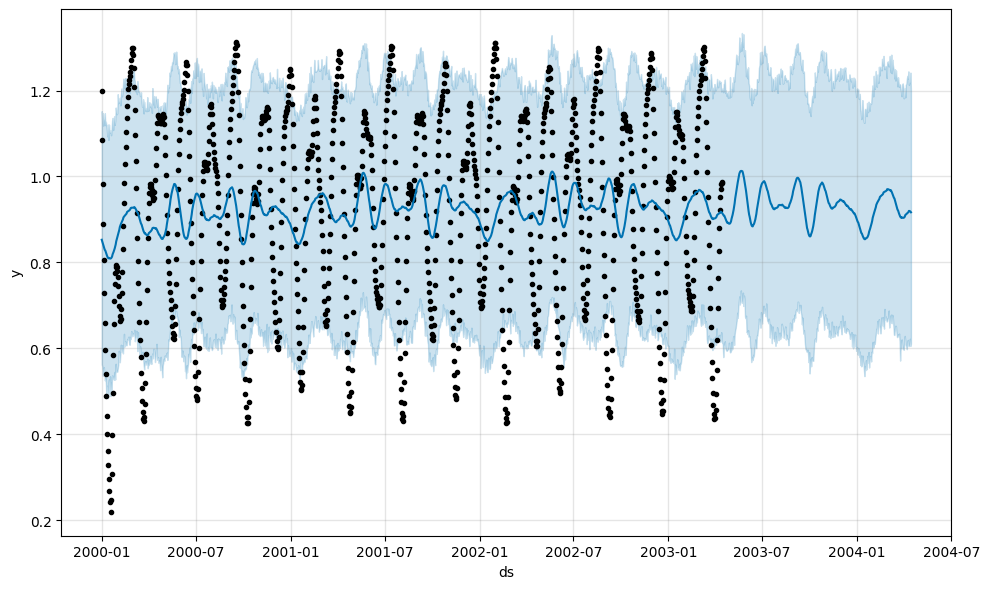

In [31]:
fig1 = m.plot(forecast)

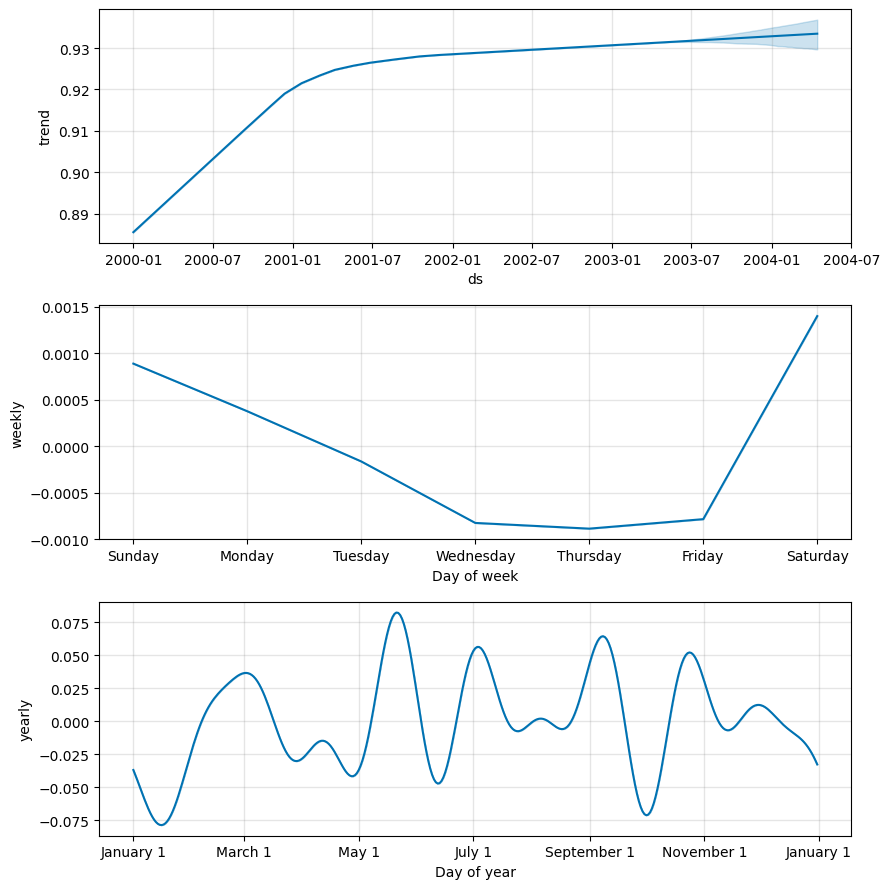

In [32]:
fig2 = m.plot_components(forecast)

Poniżej interaktywne wykresy `plotly`.

In [33]:
from prophet.plot import plot_plotly, plot_components_plotly

plot_plotly(m, forecast)

In [34]:
plot_components_plotly(m, forecast)

### Walidacja krzyżowa

Poszukiwanie najlepszych hiperparametrów.

In [38]:
import itertools
from prophet.diagnostics import performance_metrics, cross_validation

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, initial='700 days', period='100 days', horizon='100 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

11:53:10 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] start processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:11 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] done processing
11:53:12 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] done processing
11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1] start processing
11:53:13 - cmdstanpy - INFO - Chain [1

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.313997
1                     0.001                     0.10  0.357225
2                     0.001                     1.00  0.360636
3                     0.001                    10.00  0.358090
4                     0.010                     0.01  0.290530
5                     0.010                     0.10  0.336280
6                     0.010                     1.00  0.337283
7                     0.010                    10.00  0.336833
8                     0.100                     0.01  0.290304
9                     0.100                     0.10  0.336024
10                    0.100                     1.00  0.336641
11                    0.100                    10.00  0.336767
12                    0.500                     0.01  0.291206
13                    0.500                     0.10  0.337946
14                    0.500                     1.00  0

In [42]:
m = Prophet(**best_params).fit(data)  # Fit model with given params
df_cv = cross_validation(m, initial='700 days', period='100 days', horizon='100 days', parallel="processes")
df_cv

11:59:54 - cmdstanpy - INFO - Chain [1] start processing
11:59:54 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] start processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing
11:59:55 - cmdstanpy - INFO - Chain [1] done processing


,ds,yhat,yhat_lower,yhat_upper,y,cutoff
0,2001-12-02,0.830761,0.566203,1.051949,1.033001,2001-12-01
1,2001-12-03,0.834885,0.597604,1.097129,1.026813,2001-12-01
2,2001-12-04,0.839646,0.586155,1.081933,1.020815,2001-12-01
3,2001-12-05,0.845393,0.584305,1.106176,1.017924,2001-12-01
4,2001-12-06,0.852027,0.605498,1.083405,1.021163,2001-12-01
...,...,...,...,...,...,...
495,2003-04-11,0.928932,0.635670,1.224576,0.951448,2003-01-05
496,2003-04-12,0.924534,0.614141,1.217102,0.971623,2003-01-05
497,2003-04-13,0.918194,0.646901,1.211466,0.982832,2003-01-05
498,2003-04-14,0.911577,0.636182,1.197085,0.986405,2003-01-05


In [43]:
df_p = performance_metrics(df_cv, rolling_window=1)
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,100 days,0.084276,0.290304,0.248426,0.310843,0.240792,0.277585,0.62


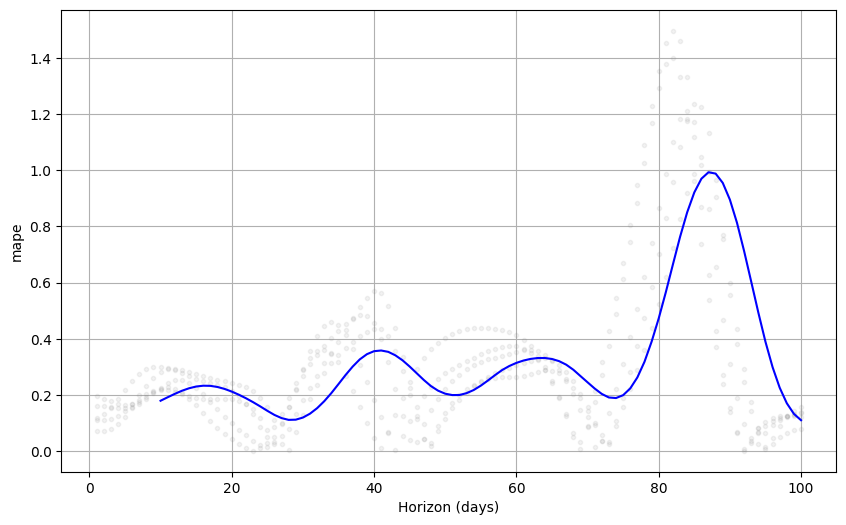

In [40]:
from prophet.plot import plot_cross_validation_metric
fig = plot_cross_validation_metric(df_cv, metric='mape')

Wykres powyżej pokazuje błąd w procenatch. Punkty to błąd dla kolejnych okien czasowych, niebieska linia to MAPE. Widać że błąd sięga w pewnym momencie 100%.

## Porównanie dla kilku zbiorów danych

In [6]:
from prophet import Prophet
from prophet.diagnostics import performance_metrics, cross_validation

### Mackey Glass

In [2]:
data = pd.read_csv("../data/mg.dat", sep=" ", index_col=0, names=["y"])
data["ds"] = pd.date_range(start="01-01-2000", periods=data.shape[0], freq="D")

,y,ds
0,1.200000,2000-01-01
1,1.085805,2000-01-02
2,0.982477,2000-01-03
3,0.888982,2000-01-04
4,0.804384,2000-01-05
5,0.727837,2000-01-06


In [3]:
test_df = data.loc[data.index >= 801].copy()
train_df =  data.loc[data.index < 801].copy()

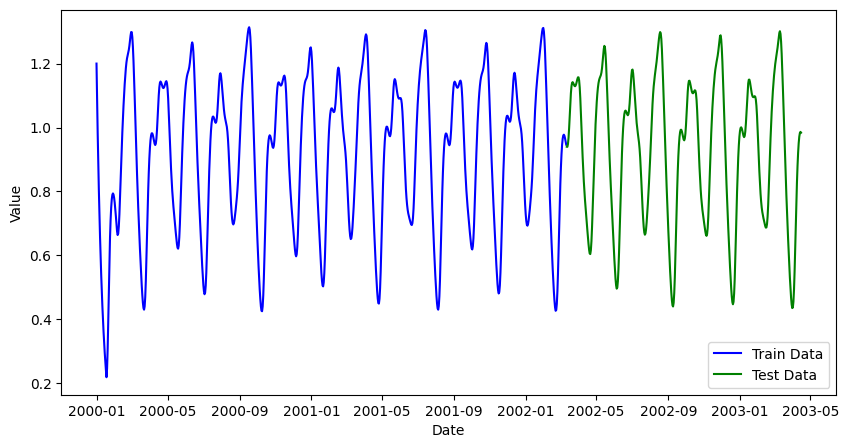

In [70]:
plt.figure(figsize=(10, 5))
plt.plot(train_df.ds, train_df.y, label="Train Data", color='blue')
plt.plot(test_df.ds, test_df.y, label="Test Data", color='green')
plt.xlabel('Date')
plt.ylabel('Value')
plt.legend()
plt.show()

In [33]:
import itertools

param_grid = {  
    'changepoint_prior_scale': [0.001, 0.01, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
rmses = []  # Store the RMSEs for each params here

# Use cross validation to evaluate all parameters
for params in all_params:
    m = Prophet(**params).fit(data)  # Fit model with given params
    df_cv = cross_validation(m, initial='800 days', period='30 days', horizon='200 days', parallel="processes")
    df_p = performance_metrics(df_cv, rolling_window=1)
    rmses.append(df_p['rmse'].values[0])

# Find the best parameters
tuning_results = pd.DataFrame(all_params)
tuning_results['rmse'] = rmses
print(tuning_results)

best_params = all_params[np.argmin(rmses)]
print(best_params)

11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] start processing
11:54:38 - cmdstanpy - INFO - Chain [1] done processing
11:54:38 - cmdstanpy - ERROR - Chain [1] error: error during processing Communication error on send
11:54:38 - cmdstanpy - INFO - Chain [1] done processing
Optimization terminated abnormally. Falling back to Newton.
11:54:39 - cmdstanpy - INFO - Chain [1] done processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing
11:54:39 - cmdstanpy - INFO - Chain [1] done processing
11:54:39 - cmdstanpy - INFO - Chain [1] done pro

    changepoint_prior_scale  seasonality_prior_scale      rmse
0                     0.001                     0.01  0.324057
1                     0.001                     0.10  0.364728
2                     0.001                     1.00  0.367002
3                     0.001                    10.00  0.367316
4                     0.010                     0.01  0.291958
5                     0.010                     0.10  0.338466
6                     0.010                     1.00  0.339246
7                     0.010                    10.00  0.339236
8                     0.100                     0.01  0.290859
9                     0.100                     0.10  0.337715
10                    0.100                     1.00  0.338345
11                    0.100                    10.00  0.338349
12                    0.500                     0.01  0.295591
13                    0.500                     0.10  0.345756
14                    0.500                     1.00  0

In [39]:
m = Prophet(**best_params)
m.fit(train_df)

future = data[["ds"]]
forecast = m.predict(future)
forecast[['ds', 'y', 'yhat', 'yhat_lower', 'yhat_upper']].tail()

11:56:54 - cmdstanpy - INFO - Chain [1] start processing
11:56:54 - cmdstanpy - INFO - Chain [1] done processing


,ds,y,yhat,yhat_lower,yhat_upper
1196,2003-04-11,0.951448,0.970709,0.676095,1.230394
1197,2003-04-12,0.971623,0.972584,0.706264,1.256793
1198,2003-04-13,0.982832,0.971077,0.688489,1.242928
1199,2003-04-14,0.986405,0.968713,0.698949,1.239573
1200,2003-04-15,0.983860,0.965183,0.694497,1.247642


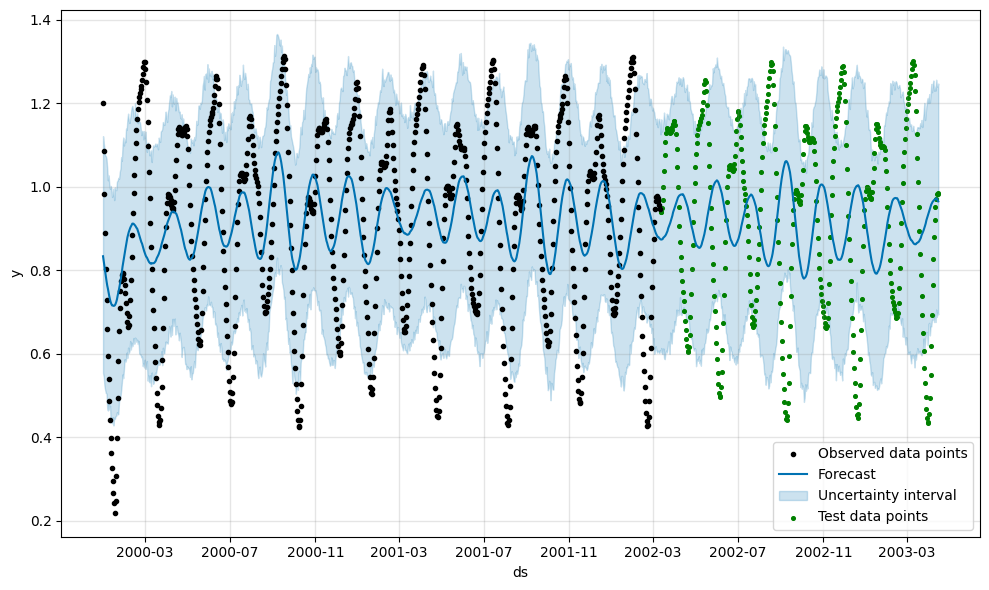

In [77]:
fig1 = m.plot(forecast)
plt.scatter(test_df["ds"], test_df["y"], c="green", s=7, label="Test data points")
plt.legend()
plt.show()

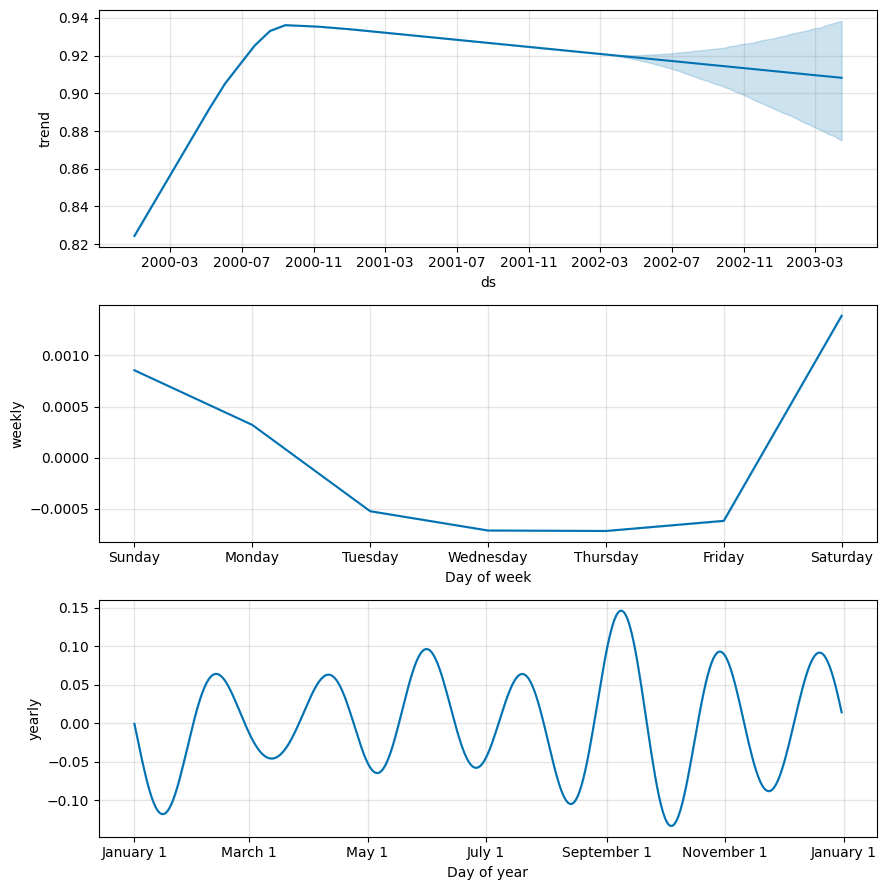

In [41]:
fig2 = m.plot_components(forecast)

10 days horizon - rmse = 0.174
50 days horizon - rmse = 0.2066
100 days horizon - rmse = 0.2553
200 days horizon - rmse = 0.2762
300 days horizon - rmse = 0.2823


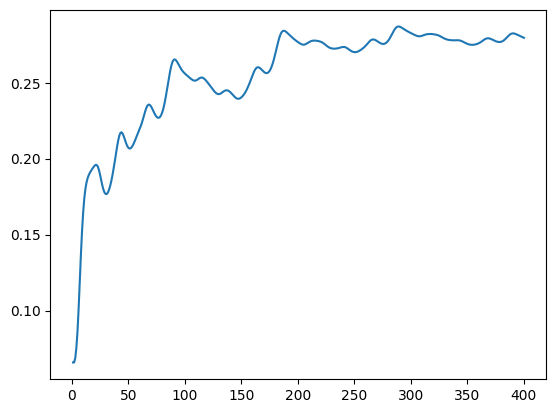

In [69]:
se = (forecast.loc[test_df.index]["yhat"] - test_df["y"]) ** 2
predicted_days = np.arange(1, se.shape[0]+1)
rmse = np.sqrt(np.cumsum(se) / predicted_days).values

for h in [10, 50, 100, 200, 300]:
    print(f"{h} days horizon - rmse = {round(rmse[h], 4)}")

plt.plot(predicted_days, rmse)
plt.show()

### Sunspots

### Electricity